## ЛР 4

In [693]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from typing import Tuple
import qpsolvers 
from qpsolvers import solve_qp 
from sklearn import svm

In [694]:
# 4 вариант
M1 = np.array([[0], 
               [0]])
M2 = np.array([[3], 
               [-3]])
M3 = np.array([[0], 
               [-2]])

B1 = np.array([[0.5, 0.1],
               [0.1, 0.5]])

B2 = np.array([[0.3, 0.1],
               [0.1, 0.3]])

B3 = np.array([[0.5, -0.1],
               [-0.1, 0.9]])

In [695]:
def get_normal_vector(M: np.ndarray, B: np.ndarray, show_print: bool = False) -> np.ndarray:
    A = np.zeros((2, 2))
    A[0, 0] = np.sqrt(B[0, 0])
    A[1, 0] = B[0, 1] / A[0, 0]
    A[1, 1] = np.sqrt(B[1, 1] - np.power(A[1, 0], 2))

    k = 30  
    
    def approx_norm():
        U = np.random.uniform(0, 1, k)
        
        return (np.sum(U) - k/2) / np.sqrt(k/12)

    E = np.array([[approx_norm()], [approx_norm()]])
    
    X = np.dot(A, E) + M

    if show_print:
        print("M: \n", M)
        print("B: \n", B)
        print("A: \n", A)
        print("E (N(0,1)): \n", E)
        print("X (N(M,B)): \n", X)

    return X



### Линейно разделимые классы

In [696]:
n = 100

In [697]:
X1_samples1 = np.array([get_normal_vector(M1, B2).flatten() for _ in range(n)])
X2_samples1 = np.array([get_normal_vector(M2, B2).flatten() for _ in range(n)])

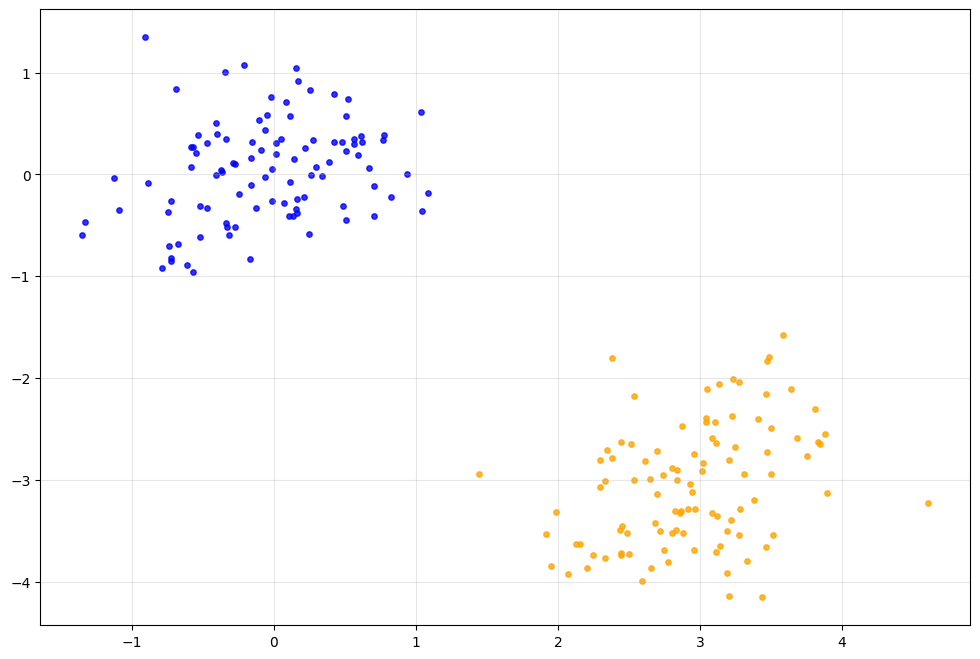

In [698]:
plt.figure(figsize=(12, 8))

plt.scatter(X1_samples1[:,0], X1_samples1[:,1], s=15, label='X1', alpha=0.8, color="blue")
plt.scatter(X2_samples1[:,0], X2_samples1[:,1], s=15, label='X2', alpha=0.8, color="orange")

plt.grid(True, alpha=0.3)
plt.show()

In [699]:
def get_support_vectors(X: np.ndarray, 
                        y: np.ndarray, 
                        min: float, 
                        max: float, 
                        epsilon: float = 1e-15
                        ) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    K = np.matmul(X, X.T)                     
    N = len(y)
    P = np.outer(y, y) * K          
    q = -np.ones(N)                 
    G = -np.eye(N)                  
    h = np.zeros(N)                
    A = y.reshape(1, -1)            
    b = np.array([0.0])             

    alpha = solve_qp(P, q, G, h, A, b, solver='cvxopt')

    y = y.ravel()
    w = np.sum((alpha * y)[:, None] * X, axis=0) 

    if alpha is not None:
        sv_idx = alpha > epsilon
        X_sv = X[sv_idx]      
        y_sv = y[sv_idx]    

        b = 0
        if np.any(sv_idx):
            wx = np.matmul(X_sv, w.T)
            b = np.mean(y_sv - wx)

        x = np.linspace(min, max, 500)
        y = -(w[0]*x + b) / w[1]
        y_plus  = -(w[0]*x + b - (1/np.linalg.norm(w))) / w[1]
        y_minus = -(w[0]*x + b + (1/np.linalg.norm(w))) / w[1]
    else: 
        return np.array([-1]), np.array([-1]), np.array([-1]), np.array([-1])     

    return x, y, y_plus, y_minus, X_sv, y_sv

# def get_support_vectors_SVC(X: np.ndarray, clf: svm.SVC, min: float, max: float) -> Tuple[np.ndarray, np.ndarray, 
#                                                                                           np.ndarray, np.ndarray]:
#     N = X.shape[0] // 2
#     y = np.hstack([np.ones(N), -np.ones(N)]).reshape(-1, 1)

#     clf.fit(X, y.ravel())

#     w = np.transpose(clf.coef_)
#     b = clf.intercept_[0]    

#     x = np.linspace(min, max, 500)
#     y = -(w[0]*x + b) / w[1]
#     y_plus  = -(w[0]*x + b - 1) / w[1]
#     y_minus = -(w[0]*x + b + 1) / w[1]    

#     return x, y, y_plus, y_minus

def get_support_vectors_SVC_universal(X: np.ndarray, clf: svm.SVC, x_min: float, x_max: float, 
                                     n_points: int = 500) -> Tuple[np.ndarray, np.ndarray, 
                                                                  np.ndarray, np.ndarray]:
    """
    Универсальная версия для линейных и нелинейных ядер
    """
    if not hasattr(clf, 'support_vectors_'):
        clf.fit(X, np.hstack([np.ones(X.shape[0] // 2), -np.ones(X.shape[0] // 2)]))
    if clf.kernel == 'linear':
        w = clf.coef_[0]
        b = clf.intercept_[0]
        
        x_line = np.linspace(x_min, x_max, n_points)
        y_line = -(w[0] * x_line + b) / (w[1] + 1e-10)
        y_plus = -(w[0] * x_line + b - (1/np.linalg.norm(w))) / (w[1] + 1e-10)
        y_minus = -(w[0] * x_line + b + (1/np.linalg.norm(w))) / (w[1] + 1e-10)
        
    else:
        x_line, y_line, y_plus, y_minus = get_nonlinear_decision_boundary(clf, x_min, x_max, n_points)
    
    return x_line, y_line, y_plus, y_minus


def get_nonlinear_decision_boundary(clf: svm.SVC, x_min: float, x_max: float, n_points: int = 500):
    """
    Строит границы решений для нелинейных SVM через контурные линии
    """
    # Создаем плотную сетку
    x = np.linspace(x_min, x_max, n_points)
    y = np.linspace(x_min, x_max, n_points)
    xx, yy = np.meshgrid(x, y)
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    
    # Получаем значения решающей функции
    Z = clf.decision_function(grid_points)
    Z = Z.reshape(xx.shape)
    
    # Инициализируем массивы для границ
    x_line = np.linspace(x_min, x_max, n_points)
    y_line = np.full(n_points, np.nan)
    y_plus = np.full(n_points, np.nan)
    y_minus = np.full(n_points, np.nan)
    
    # Для каждого x находим y, где Z ≈ 0, 1, -1
    for i, x_val in enumerate(x):
        # Находим индексы, где x близко к x_val
        x_idx = np.argmin(np.abs(x - x_val))
        
        # Ищем пересечения с уровнями
        z_slice = Z[x_idx, :]
        
        # Уровень 0 (основная граница)
        zero_crossings = find_zero_crossings(y, z_slice)
        if len(zero_crossings) > 0:
            y_line[i] = zero_crossings[0]
        
        # Уровень 1 (верхняя граница)
        plus_crossings = find_level_crossings(y, z_slice, level=1)
        if len(plus_crossings) > 0:
            y_plus[i] = plus_crossings[0]
        
        # Уровень -1 (нижняя граница)
        minus_crossings = find_level_crossings(y, z_slice, level=-1)
        if len(minus_crossings) > 0:
            y_minus[i] = minus_crossings[0]
    
    # Интерполируем пропущенные значения
    y_line = interpolate_missing(y_line)
    y_plus = interpolate_missing(y_plus)
    y_minus = interpolate_missing(y_minus)
    
    return x_line, y_line, y_plus, y_minus


def find_zero_crossings(x, y):
    """Находит точки пересечения нуля"""
    crossings = []
    for i in range(len(y) - 1):
        if y[i] * y[i + 1] <= 0:  # Знак меняется
            # Линейная интерполяция
            x_cross = x[i] - y[i] * (x[i + 1] - x[i]) / (y[i + 1] - y[i] + 1e-10)
            crossings.append(x_cross)
    return crossings


def find_level_crossings(x, y, level=0):
    """Находит точки пересечения заданного уровня"""
    y_shifted = y - level
    return find_zero_crossings(x, y_shifted)


def interpolate_missing(y):
    """Интерполирует пропущенные значения в массиве"""
    if np.all(np.isnan(y)):
        return y
    
    x_indices = np.arange(len(y))
    valid_mask = ~np.isnan(y)
    
    if np.sum(valid_mask) < 2:
        return y
    
    from scipy.interpolate import interp1d
    interp_func = interp1d(x_indices[valid_mask], y[valid_mask], 
                          kind='linear', bounds_error=False, 
                          fill_value="extrapolate")
    return interp_func(x_indices)

def get_support_vectors_LinearSVC(X: np.ndarray, clf: svm.LinearSVC, min: float, max: float) -> Tuple[np.ndarray, np.ndarray, 
                                                                                                      np.ndarray, np.ndarray]:
    N = X.shape[0] // 2
    y = np.hstack([np.ones(N), -np.ones(N)]).reshape(-1, 1)

    clf.fit(X, y.ravel())

    w = np.transpose(clf.coef_)
    b = clf.intercept_[0]    

    # x = np.linspace(min, max, 500)
    # y = -(w[0]*x + b) / w[1]
    # y_plus  = -(w[0]*x + b - (1/np.linalg.norm(w))) / w[1]
    # y_minus = -(w[0]*x + b + (1/np.linalg.norm(w))) / w[1]    

    x = np.linspace(min, max, 500)
    y = -(w[0] * x + b) / (w[1] + 1e-10)
    y_plus = -(w[0] * x + b - (1/np.linalg.norm(w))) / (w[1] + 1e-10)
    y_minus = -(w[0] * x + b + (1/np.linalg.norm(w))) / (w[1] + 1e-10)

    return x, y, y_plus, y_minus

def Bayes_Classificator(M1: np.ndarray, M2: np.ndarray, 
                        B: np.ndarray, min: float, max: float, 
                        prob1: float, prob2: float) -> Tuple[np.ndarray, np.ndarray]:
    x = np.linspace(min, max, 200)

    B_inv = np.linalg.inv(B)
    a = np.dot((M1 - M2).T,  B_inv)
    b = -0.5 * np.dot(np.dot((M1 + M2).T, B_inv), (M1 - M2)) + np.log(prob1 / prob2)

    y = (-a[0] * x - b) / a[1]

    return x, y

In [700]:
min_X1_X2 = np.min(np.concatenate((X1_samples1[:, 0], X2_samples1[:, 0])))
max_X1_X2 = np.max(np.concatenate((X1_samples1[:, 0], X2_samples1[:, 0])))

In [701]:
x_Bayes, y_Bayes = Bayes_Classificator(M1.reshape(1, -1)[0], M2.reshape(1, -1)[0], B2, min_X1_X2, max_X1_X2, 0.5, 0.5)  

In [702]:
X_samples1 = np.concatenate((X1_samples1, X2_samples1), axis=0) 
y_samples1 = np.hstack([np.ones(100), -np.ones(100)]).reshape(-1, 1)

x, y, y_plus, y_minus, X_sv, y_sv = get_support_vectors(X_samples1, y_samples1, min_X1_X2, max_X1_X2, epsilon=1e-7)

clf_svc = svm.SVC(kernel="linear")
x_svc, y_svc, y_plus_svc, y_minus_svc = get_support_vectors_SVC_universal(X_samples1, clf_svc, min_X1_X2, max_X1_X2)

clf_linear_svc = svm.LinearSVC(dual="auto")
x_linear_svc, y_linear_svc, y_plus_linear_svc, y_minus_linear_svc = get_support_vectors_LinearSVC(X_samples1, clf_linear_svc, min_X1_X2, max_X1_X2)

In [703]:
from sklearn.inspection import DecisionBoundaryDisplay

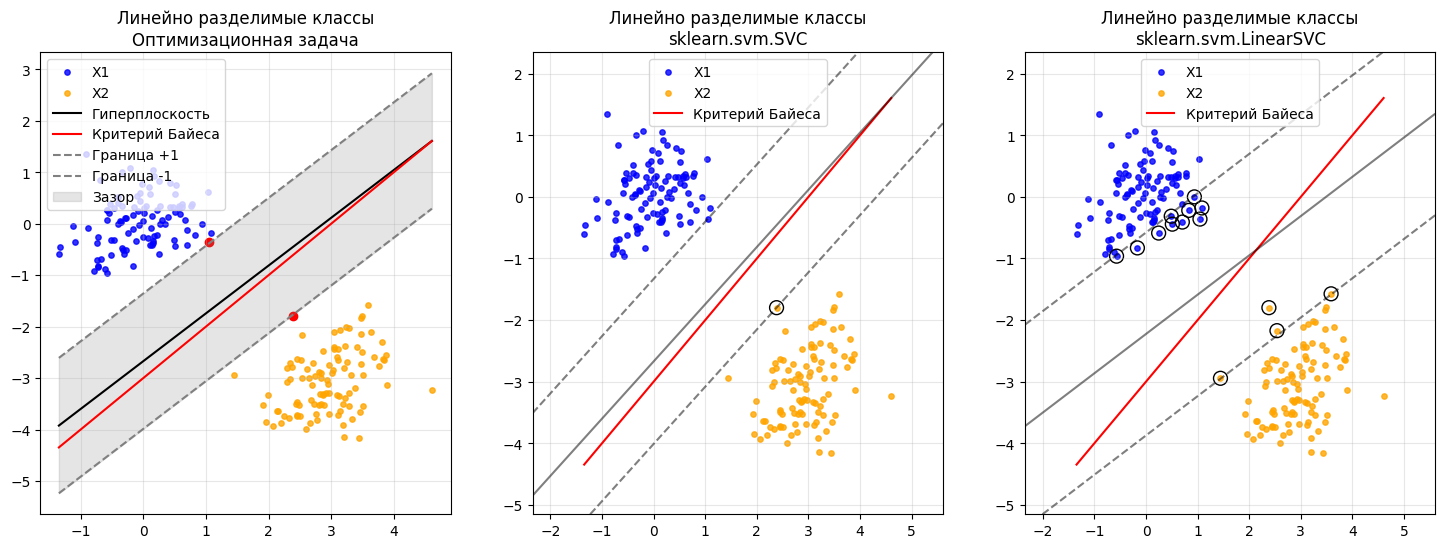

In [704]:
plt.figure(figsize=(18,6))

plt.subplot(1,3,1)
plt.title("Линейно разделимые классы\nОптимизационная задача")
plt.scatter(X1_samples1[:,0], X1_samples1[:,1], s=15, label='X1', alpha=0.8, color="blue")
plt.scatter(X2_samples1[:,0], X2_samples1[:,1], s=15, label='X2', alpha=0.8, color="orange")
plt.scatter(X_sv[:,0], X_sv[:,1], color="red")
plt.plot(x, y, label='Гиперплоскость', color="black")
plt.plot(x_Bayes, y_Bayes, label='Критерий Байеса', color="red")
plt.plot(x, y_plus, label='Граница +1', color='gray', linestyle="--")
plt.plot(x, y_minus, label='Граница -1', color='gray', linestyle="--")
plt.fill_between(x, y_minus, y_plus, color='gray', alpha=0.2, label='Зазор')
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(1,3,2)
plt.title("Линейно разделимые классы\nsklearn.svm.SVC")
plt.scatter(X1_samples1[:,0], X1_samples1[:,1], s=15, label='X1', alpha=0.8, color="blue")
plt.scatter(X2_samples1[:,0], X2_samples1[:,1], s=15, label='X2', alpha=0.8, color="orange")
# plt.plot(x_svc, y_svc, label='Гиперплоскость', color="black")
plt.plot(x_Bayes, y_Bayes, label='Критерий Байеса', color="red")
# plt.plot(x_svc, y_plus_svc, label='Граница +1', color='gray', linestyle="--")
# plt.plot(x_svc, y_minus_svc, label='Граница -1', color='gray', linestyle="--")
# plt.fill_between(x_svc, y_minus_svc, y_plus_svc, color='gray', alpha=0.2, label='Зазор')
decision_vals = clf_svc.decision_function(X_samples1)
support_vector_indices = np.where(np.abs(decision_vals) <= 1 + 1e-15)[0]
support_vectors = X_samples1[support_vector_indices]
ax = plt.gca()
DecisionBoundaryDisplay.from_estimator(
        clf_svc,
        X_samples1,
        ax=ax,
        grid_resolution=50,
        plot_method="contour",
        colors="k",
        levels=[-1, 0, 1],
        alpha=0.5,
        linestyles=["--", "-", "--"],
    )
plt.scatter(
        support_vectors[:, 0],
        support_vectors[:, 1],
        s=100,
        linewidth=1,
        facecolors="none",
        edgecolors="k",
    )
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(1,3,3)
plt.title("Линейно разделимые классы\nsklearn.svm.LinearSVC")
plt.scatter(X1_samples1[:,0], X1_samples1[:,1], s=15, label='X1', alpha=0.8, color="blue")
plt.scatter(X2_samples1[:,0], X2_samples1[:,1], s=15, label='X2', alpha=0.8, color="orange")
# plt.plot(x_linear_svc, y_linear_svc, label='Гиперплоскость', color="black")
plt.plot(x_Bayes, y_Bayes, label='Критерий Байеса', color="red")
# plt.plot(x_linear_svc, y_plus_linear_svc, label='Граница +1', color='gray', linestyle="--")
# plt.plot(x_linear_svc, y_minus_linear_svc, label='Граница -1', color='gray', linestyle="--")
# plt.fill_between(x_linear_svc, y_minus_linear_svc, y_plus_linear_svc, color='gray', alpha=0.2, label='Зазор')

decision_vals = clf_linear_svc.decision_function(X_samples1)
support_vector_indices = np.where(np.abs(decision_vals) <= 1 + 1e-15)[0]
support_vectors = X_samples1[support_vector_indices]
ax = plt.gca()
DecisionBoundaryDisplay.from_estimator(
        clf_linear_svc,
        X_samples1,
        ax=ax,
        grid_resolution=50,
        plot_method="contour",
        colors="k",
        levels=[-1, 0, 1],
        alpha=0.5,
        linestyles=["--", "-", "--"],
    )
plt.scatter(
        support_vectors[:, 0],
        support_vectors[:, 1],
        s=100,
        linewidth=1,
        facecolors="none",
        edgecolors="k",
    )
# x_linear_svc = np.linspace(float(min_X1_X2), float(max_X1_X2), len(support_vectors[:,0]))
# plt.fill_between(x_linear_svc, color='gray', alpha=0.2, label='Зазор')
# try:
#     # decision_vals = clf_linear_svc.decision_function(X_samples1)
#     # margin_mask = np.abs(decision_vals) < 1.0
#     support_vector_indices = np.where(np.abs(decision_vals) <= 1 + 1e-15)[0]
#     support_vectors = X[support_vector_indices]
#     if np.any(margin_mask):
#         plt.scatter(X_samples1[margin_mask,0], X_samples1[margin_mask,1], s=40, color='red', label='В зазоре', zorder=5)
# except Exception:
#     pass
plt.grid(True, alpha=0.3)
plt.legend()

plt.show()

### Линейно неразделимые классы

In [705]:
X1_samples2 = np.array([get_normal_vector(M1, B1).flatten() for _ in range(n)])
X2_samples2 = np.array([get_normal_vector(M3, B3).flatten() for _ in range(n)])

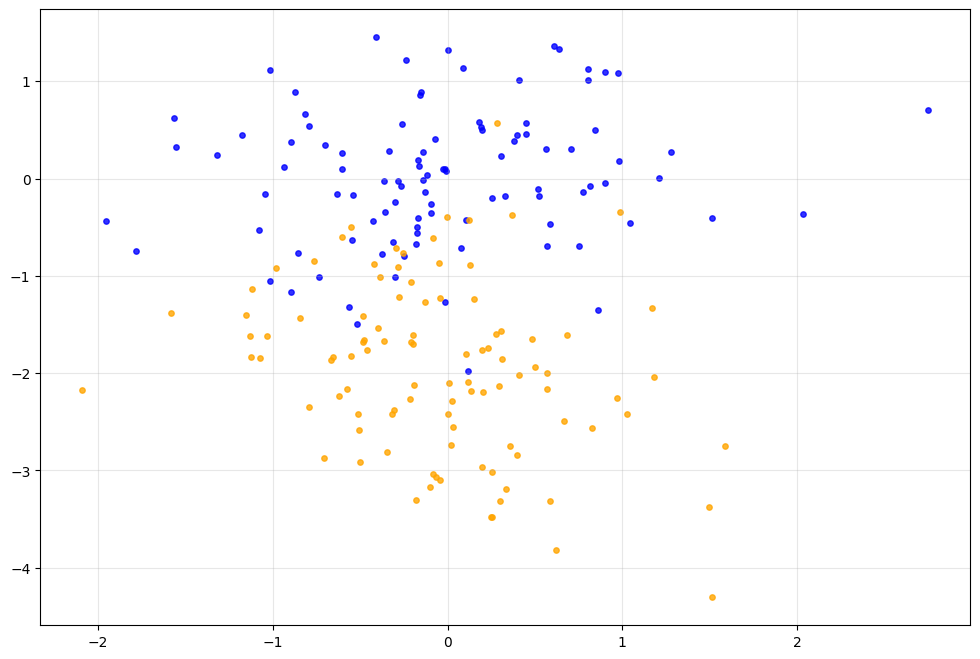

In [706]:
plt.figure(figsize=(12, 8))

plt.scatter(X1_samples2[:,0], X1_samples2[:,1], s=15, label='X1', alpha=0.8, color="blue")
plt.scatter(X2_samples2[:,0], X2_samples2[:,1], s=15, label='X2', alpha=0.8, color="orange")

plt.grid(True, alpha=0.3)
plt.show()

In [707]:
def get_support_vectors(X: np.ndarray, y: np.ndarray, 
                        C: float, x_min: float, x_max: float, 
                        epsilon: float = 1e-15,
                        kernel: str = "polynomial_homo",
                        degree = 2,
                        ) -> Tuple[np.ndarray, np.ndarray, 
                                                         np.ndarray, np.ndarray]:    
    K = None
    if kernel == "linear":
        K = np.dot(X, X.T)
    elif kernel == "polynomial_homo":
        K = np.dot(X, X.T) ** degree    
    elif kernel == "polynomial_non-homo":
        K = (np.dot(X, X.T) + 1) ** degree
    elif kernel == "radial":
        gamma = 1.0 / X.shape[1]
        X_norm = np.sum(X**2, axis=1)
        K = np.exp(-gamma * (X_norm[:, None] + X_norm[None, :] - 2 * np.dot(X, X.T)))
    elif kernel == "gaussian_radial":
        variances = np.var(X, axis=0, ddof=1)
        sigma_sq = np.mean(variances) 
        X_norm = np.sum(X**2, axis=1)
        K = np.exp(-(X_norm[:, None] + X_norm[None, :] - 2 * np.dot(X, X.T)) / (2 * sigma_sq))
    else:
        raise ValueError(f"Неизвестное ядро: {kernel}")
    
    N = len(y)

    P = np.outer(y, y) * K          
    q = -np.ones(N)                 
    G = np.vstack((-np.eye(N), np.eye(N)))  
    h = np.hstack((np.zeros(N), np.full(N, C)))             
    A = y.reshape(1, -1).astype(float)  
    b = np.array([0.0])             

    alpha = solve_qp(P, q, G, h, A, b, solver="cvxopt")
    y = y.ravel()
    support_indices = (alpha > epsilon)
    
    w = np.zeros(X.shape[1])
    if kernel in ["linear", "polynomial_homo", "polynomial_non-homo"]:
        w = np.sum((alpha * y)[:, None] * X, axis=0)
    
    marginal_sv_indices = (alpha > epsilon) & (alpha < C - epsilon)
    
    b = 0.0
    if np.any(marginal_sv_indices):
        X_marginal = X[marginal_sv_indices]
        y_marginal = y[marginal_sv_indices]
        alpha_marginal = alpha[marginal_sv_indices]
        
        if kernel in ["linear", "polynomial_homo", "polynomial_non-homo"]:
            wx = np.dot(X_marginal, w)
            b = np.mean(y_marginal - wx)
        else:
            K_marginal = K[marginal_sv_indices][:, support_indices]
            predictions = np.dot(K_marginal, alpha[support_indices] * y[support_indices])
            b = np.mean(y_marginal - predictions)
    
    if X.shape[1] == 2 and kernel in ["linear", "polynomial_homo", "polynomial_non-homo"]:
        x_line = np.linspace(x_min, x_max, 500)
        y_line = -(w[0] * x_line + b) / w[1]
        y_plus = -(w[0] * x_line + b - 1) / w[1]
        y_minus = -(w[0] * x_line + b + 1) / w[1]
    else:
        x_line = np.array([])
        y_line = np.array([])
        y_plus = np.array([])
        y_minus = np.array([])
    
    return x_line, y_line, y_plus, y_minus, X_marginal, y_marginal

def fit_line_from_points(x: np.ndarray, y: np.ndarray, degree=1) -> tuple:
    if degree == 1:
        a, b = np.polyfit(x, y, deg=degree)
        eq = f'y = {a:.6f} * x + {b:.6f}'
        return float(a), float(b), eq
    elif degree == 2:
        a, b, c = np.polyfit(x, y, deg=degree)
        eq = f'y = {a:.6f} * x^2 + {b:.6f} * x + {c:.6f}'
        return float(a), float(b), float(c), eq
    else:
        return None

def compute_number_errors2(X1: np.ndarray, X2: np.ndarray, 
                          coef_a: float, coef_b: float) -> Tuple[float, float]:
    n = X1.shape[0]
    
    count_errors_I = 0
    for vector in X1:
        if np.abs(coef_a * vector[0] + coef_b) > np.abs(vector[1]):
            count_errors_I += 1
    err_I = float(count_errors_I / n)

    count_errors_II = 0
    for vector in X2:
        if np.abs(coef_a * vector[0] + coef_b) < np.abs(vector[1]):
            count_errors_II += 1
    err_II = float(count_errors_II / n)      

    return err_I, err_II

In [708]:
min_X1_X2_2 = np.min(np.concatenate((X1_samples2[:, 0], X2_samples2[:, 0])))
max_X1_X2_2 = np.max(np.concatenate((X1_samples2[:, 0], X2_samples2[:, 0])))

In [709]:
x_Bayes, y_Bayes = Bayes_Classificator(M1.reshape(1, -1)[0], M3.reshape(1, -1)[0], B2, min_X1_X2_2, max_X1_X2_2, 0.5, 0.5) 

In [710]:
X_samples2 = np.concatenate((X1_samples2, X2_samples2), axis=0) 
y_samples2 = np.hstack([np.ones(100), -np.ones(100)]).reshape(-1, 1)
C = np.array([0.1, 1, 10])

x1, y1, y_plus1, y_minus1, X_sv11, y_sv11 = get_support_vectors(X_samples2, y_samples2, C[0], min_X1_X2_2, max_X1_X2_2, epsilon=0.01, kernel='linear')
x2, y2, y_plus2, y_minus2, X_sv2, y_sv2 = get_support_vectors(X_samples2, y_samples2, C[1], min_X1_X2_2, max_X1_X2_2, epsilon=0.01, kernel='linear')
x3, y3, y_plus3, y_minus3, X_sv3, y_sv3 = get_support_vectors(X_samples2, y_samples2, C[2], min_X1_X2_2, max_X1_X2_2, epsilon=0.01, kernel='linear')

In [711]:
clf1 = svm.SVC(kernel="linear", C=C[0])
x1_svc, y1_svc, y_plus1_svc, y_minus1_svc = get_support_vectors_SVC_universal(X_samples2, clf1, min_X1_X2_2, max_X1_X2_2)
clf2 = svm.SVC(kernel="linear", C=C[1])
x2_svc, y2_svc, y_plus2_svc, y_minus2_svc = get_support_vectors_SVC_universal(X_samples2, clf2, min_X1_X2_2, max_X1_X2_2)
clf3 = svm.SVC(kernel="linear", C=C[2])
x3_svc, y3_svc, y_plus3_svc, y_minus3_svc = get_support_vectors_SVC_universal(X_samples2, clf3, min_X1_X2_2, max_X1_X2_2)

In [712]:
def get_scatter(X: np.ndarray, 
                coef_a: float, coef_b: float, 
                predicat: str) -> np.ndarray:

    errors = []
    for vector in X:
        if predicat == "more":
            if coef_a * vector[0] + coef_b > vector[1]:
                errors.append(vector)
        elif predicat == "less":
            if coef_a * vector[0] + coef_b < vector[1]:
                errors.append(vector)         

    return np.array(errors)


In [713]:
a11, b11, eq11 = fit_line_from_points(x1, y_minus1)
a12, b12, eq12 = fit_line_from_points(x1, y_plus1)
points11 = get_scatter(X2_samples2, a11, b11, "less")
points12 = get_scatter(X1_samples2, a12, b12, "more")

a21, b21, eq21= fit_line_from_points(x2, y_minus2)
a22, b22, eq22 = fit_line_from_points(x2, y_plus2)
points21 = get_scatter(X2_samples2, a21, b21, "less")
points22 = get_scatter(X1_samples2, a22, b22, "more")

a31, b31, eq31 = fit_line_from_points(x3, y_minus3)
a32, b32, eq32 = fit_line_from_points(x3, y_plus3)
points31 = get_scatter(X2_samples2, a31, b31, "less")
points32 = get_scatter(X1_samples2, a32, b32, "more")

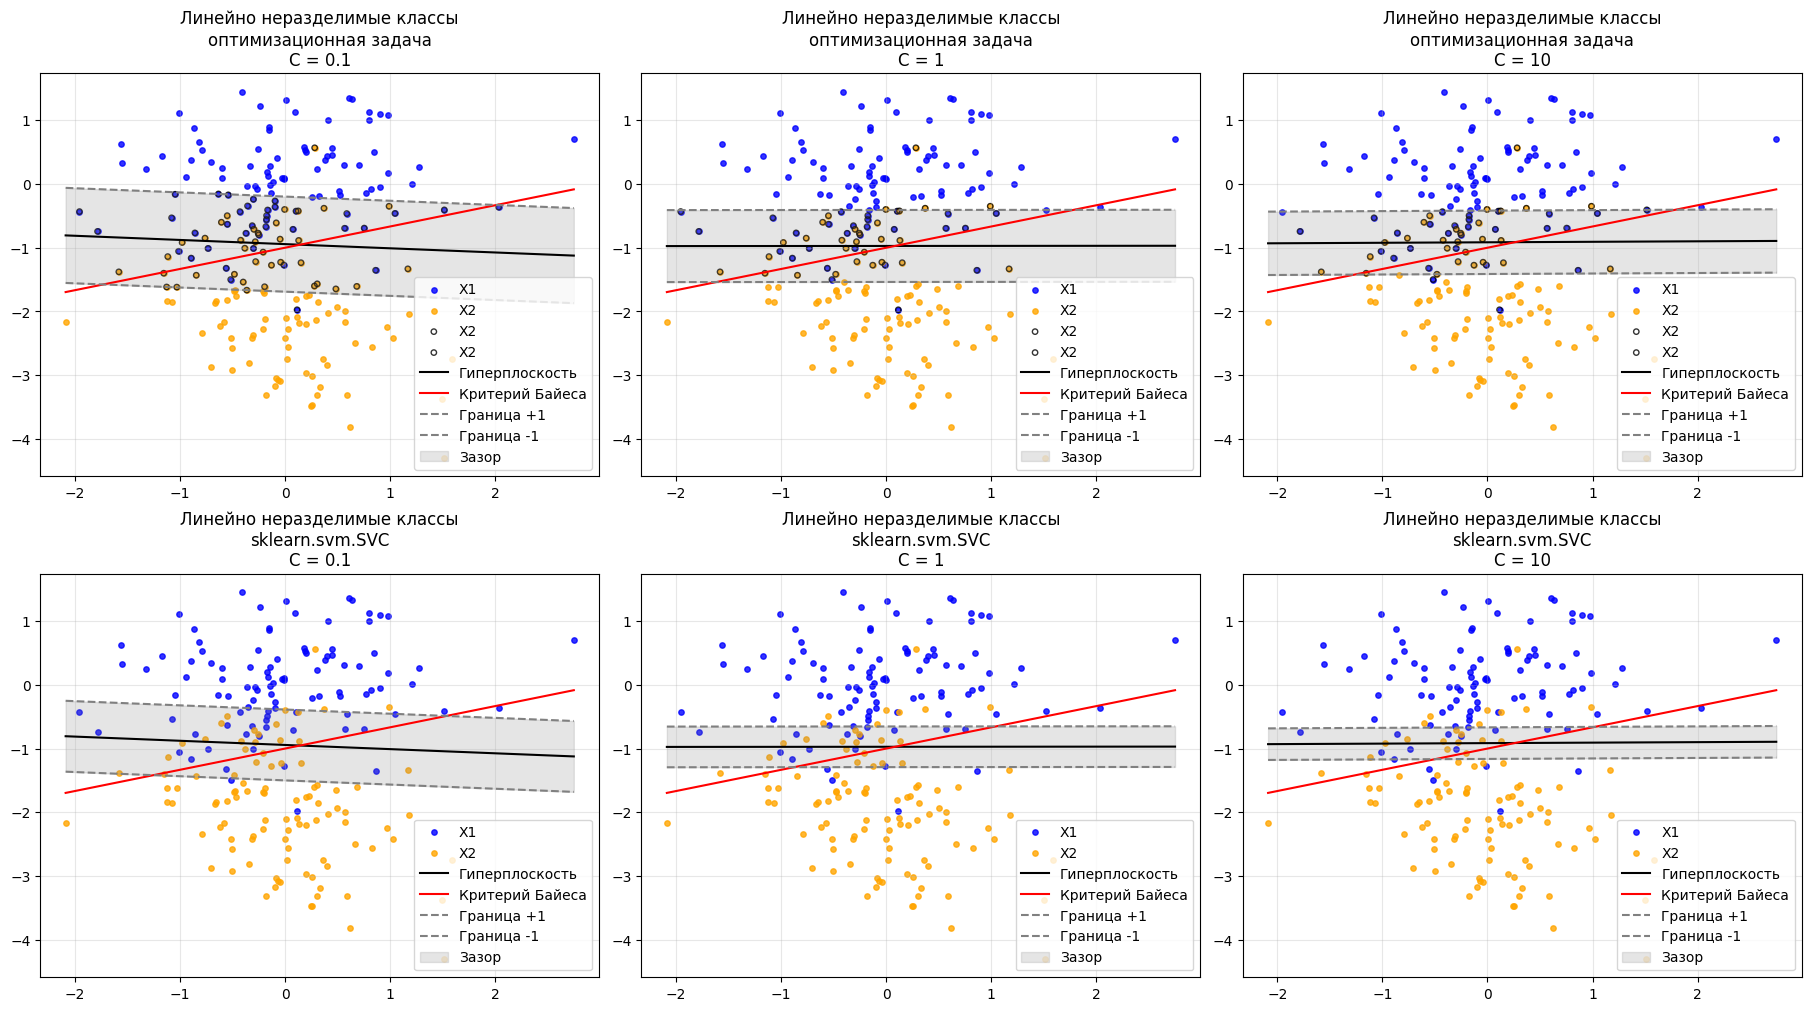

In [714]:
plt.figure(figsize=(18,10), constrained_layout=True)

plt.subplot(2,3,1)
plt.title("Линейно неразделимые классы\nоптимизационная задача\nC = 0.1")
plt.scatter(X1_samples2[:,0], X1_samples2[:,1], s=15, label='X1', alpha=0.8, color="blue")
plt.scatter(X2_samples2[:,0], X2_samples2[:,1], s=15, label='X2', alpha=0.8, color="orange")
# plt.scatter(X_sv[:,0], X_sv[:,1], color="red")
plt.scatter(points11[:,0], points11[:,1], s=15, label='X2', alpha=0.8, linewidth=1, facecolors="none", edgecolors="k")
plt.scatter(points12[:,0], points12[:,1], s=15, label='X2', alpha=0.8, linewidth=1, facecolors="none", edgecolors="k")
plt.plot(x1, y1, label='Гиперплоскость', color="black")
plt.plot(x_Bayes, y_Bayes, label='Критерий Байеса', color="red")
plt.plot(x1, y_plus1, label='Граница +1', color='gray', linestyle="--")
plt.plot(x1, y_minus1, label='Граница -1', color='gray', linestyle="--")
plt.fill_between(x1, y_minus1, y_plus1, color='gray', alpha=0.2, label='Зазор')
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(2,3,2)
plt.title("Линейно неразделимые классы\nоптимизационная задача\nC = 1")
plt.scatter(X1_samples2[:,0], X1_samples2[:,1], s=15, label='X1', alpha=0.8, color="blue")
plt.scatter(X2_samples2[:,0], X2_samples2[:,1], s=15, label='X2', alpha=0.8, color="orange")
# plt.scatter(X_sv[:,0], X_sv[:,1], color="red")
plt.scatter(points21[:,0], points21[:,1], s=15, label='X2', alpha=0.8, linewidth=1, facecolors="none", edgecolors="k")
plt.scatter(points22[:,0], points22[:,1], s=15, label='X2', alpha=0.8, linewidth=1, facecolors="none", edgecolors="k")
plt.plot(x2, y2, label='Гиперплоскость', color="black")
plt.plot(x_Bayes, y_Bayes, label='Критерий Байеса', color="red")
plt.plot(x2, y_plus2, label='Граница +1', color='gray', linestyle="--")
plt.plot(x2, y_minus2, label='Граница -1', color='gray', linestyle="--")
plt.fill_between(x2, y_minus2, y_plus2, color='gray', alpha=0.2, label='Зазор')
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(2,3,3)
plt.title("Линейно неразделимые классы\nоптимизационная задача\nC = 10")
plt.scatter(X1_samples2[:,0], X1_samples2[:,1], s=15, label='X1', alpha=0.8, color="blue")
plt.scatter(X2_samples2[:,0], X2_samples2[:,1], s=15, label='X2', alpha=0.8, color="orange")
plt.scatter(points31[:,0], points31[:,1], s=15, label='X2', alpha=0.8, linewidth=1, facecolors="none", edgecolors="k")
plt.scatter(points32[:,0], points32[:,1], s=15, label='X2', alpha=0.8, linewidth=1, facecolors="none", edgecolors="k")
plt.plot(x3, y3, label='Гиперплоскость', color="black")
plt.plot(x_Bayes, y_Bayes, label='Критерий Байеса', color="red")
plt.plot(x3, y_plus3, label='Граница +1', color='gray', linestyle="--")
plt.plot(x3, y_minus3, label='Граница -1', color='gray', linestyle="--")
plt.fill_between(x3, y_minus3, y_plus3, color='gray', alpha=0.2, label='Зазор')
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(2,3,4)
plt.title("Линейно неразделимые классы\nsklearn.svm.SVC\nC = 0.1")
plt.scatter(X1_samples2[:,0], X1_samples2[:,1], s=15, label='X1', alpha=0.8, color="blue")
plt.scatter(X2_samples2[:,0], X2_samples2[:,1], s=15, label='X2', alpha=0.8, color="orange")
plt.plot(x1_svc, y1_svc, label='Гиперплоскость', color="black")
plt.plot(x_Bayes, y_Bayes, label='Критерий Байеса', color="red")
plt.plot(x1_svc, y_plus1_svc, label='Граница +1', color='gray', linestyle="--")
plt.plot(x1_svc, y_minus1_svc, label='Граница -1', color='gray', linestyle="--")
plt.fill_between(x1_svc, y_minus1_svc, y_plus1_svc, color='gray', alpha=0.2, label='Зазор')
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(2,3,5)
plt.title("Линейно неразделимые классы\nsklearn.svm.SVC\nC = 1")
plt.scatter(X1_samples2[:,0], X1_samples2[:,1], s=15, label='X1', alpha=0.8, color="blue")
plt.scatter(X2_samples2[:,0], X2_samples2[:,1], s=15, label='X2', alpha=0.8, color="orange")
plt.plot(x2_svc, y2_svc, label='Гиперплоскость', color="black")
plt.plot(x_Bayes, y_Bayes, label='Критерий Байеса', color="red")
plt.plot(x2_svc, y_plus2_svc, label='Граница +1', color='gray', linestyle="--")
plt.plot(x2_svc, y_minus2_svc, label='Граница -1', color='gray', linestyle="--")
plt.fill_between(x2_svc, y_minus2_svc, y_plus2_svc, color='gray', alpha=0.2, label='Зазор')
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(2,3,6)
plt.title("Линейно неразделимые классы\nsklearn.svm.SVC\nC = 10")
plt.scatter(X1_samples2[:,0], X1_samples2[:,1], s=15, label='X1', alpha=0.8, color="blue")
plt.scatter(X2_samples2[:,0], X2_samples2[:,1], s=15, label='X2', alpha=0.8, color="orange")
plt.plot(x3_svc, y3_svc, label='Гиперплоскость', color="black")
plt.plot(x_Bayes, y_Bayes, label='Критерий Байеса', color="red")
plt.plot(x3_svc, y_plus3_svc, label='Граница +1', color='gray', linestyle="--")
plt.plot(x3_svc, y_minus3_svc, label='Граница -1', color='gray', linestyle="--")
plt.fill_between(x3_svc, y_minus3_svc, y_plus3_svc, color='gray', alpha=0.2, label='Зазор')
plt.grid(True, alpha=0.3)
plt.legend()

plt.show()

In [715]:
a, b, eq = fit_line_from_points(x_Bayes, y_Bayes)
a1, b1, eq1 = fit_line_from_points(x1, y1)
a2, b2, eq2 = fit_line_from_points(x2, y2)
a3, b3, eq3 = fit_line_from_points(x2, y2)

In [716]:
p0_Bayes_exp, p1_Bayes_exp = compute_number_errors2(X2_samples2, X1_samples2, a, b)
print("Байесовский классификатор")
print(f"Экспериментальная вероятность ошибки первого рода: {p0_Bayes_exp:.5f}")
print(f"Экспериментальная вероятность ошибки второго рода: {p1_Bayes_exp:.5f}\n")

p0_exp1, p1_exp1 = compute_number_errors2(X2_samples2, X1_samples2, a1, b1)
print("Метод опорных векторов, C = 0.1")
print(f"Экспериментальная вероятность ошибки первого рода: {p0_exp1:.5f}")
print(f"Экспериментальная вероятность ошибки второго рода: {p1_exp1:.5f}\n")

p0_exp2, p1_exp2 = compute_number_errors2(X2_samples2, X1_samples2, a2, b2)
print("Метод опорных векторов, C = 1")
print(f"Экспериментальная вероятность ошибки первого рода: {p0_exp2:.5f}")
print(f"Экспериментальная вероятность ошибки второго рода: {p1_exp2:.5f}\n")

p0_exp3, p1_exp3 = compute_number_errors2(X2_samples2, X1_samples2, a3, b3)
print("Метод опорных векторов, C = 10")
print(f"Экспериментальная вероятность ошибки первого рода: {p0_exp3:.5f}")
print(f"Экспериментальная вероятность ошибки второго рода: {p1_exp3:.5f}\n")


Байесовский классификатор
Экспериментальная вероятность ошибки первого рода: 0.20000
Экспериментальная вероятность ошибки второго рода: 0.18000

Метод опорных векторов, C = 0.1
Экспериментальная вероятность ошибки первого рода: 0.15000
Экспериментальная вероятность ошибки второго рода: 0.21000

Метод опорных векторов, C = 1
Экспериментальная вероятность ошибки первого рода: 0.16000
Экспериментальная вероятность ошибки второго рода: 0.21000

Метод опорных векторов, C = 10
Экспериментальная вероятность ошибки первого рода: 0.16000
Экспериментальная вероятность ошибки второго рода: 0.21000



In [717]:
y_plus1[0] - y_minus1[0]
y_plus1[2] - y_minus1[2]

np.float64(1.4929274579577014)

In [719]:
c = np.linspace(0.1, 5, 50)
length_list = []
for val in c:
    x1, y1, y_plus1, y_minus1, X_sv11, y_sv11 = get_support_vectors(X_samples2, y_samples2, val, min_X1_X2_2, max_X1_X2_2, epsilon=0.01, kernel='linear')
    length_list.append(y_plus1[0] - y_minus1[0])

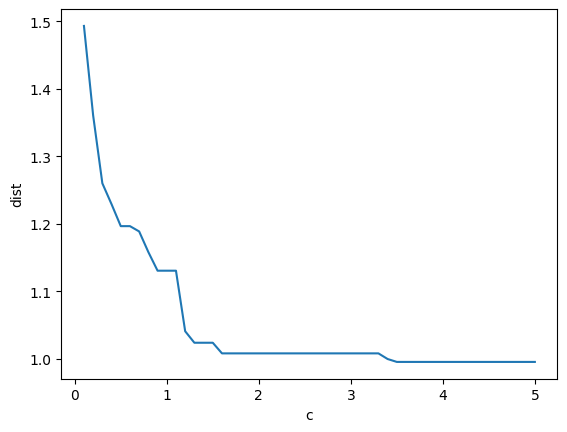

In [721]:
plt.plot(c, length_list)
plt.ylabel("dist")
plt.xlabel("c")
plt.show()

In [ ]:
kernels = ["polynomial_homo", "polynomial_non-homo", "radial", "gaussian_radial"]

xk1, yk1, yk_plus1, yk_minus1, X_svk, y_svk = get_support_vectors(X_samples2, y_samples2, C[1], min_X1_X2_2, max_X1_X2_2, epsilon=0.01, kernel=kernels[1])
xk2, yk2, yk_plus2, yk_minus2, X_svk, y_svk = get_support_vectors(X_samples2, y_samples2, C[1], min_X1_X2_2, max_X1_X2_2, epsilon=0.01, kernel=kernels[2])
xk3, yk3, yk_plus3, yk_minus3, X_svk, y_svk = get_support_vectors(X_samples2, y_samples2, C[1], min_X1_X2_2, max_X1_X2_2, epsilon=0.01, kernel=kernels[3])

clf1 = svm.SVC(kernel="poly", C=C[1], coef0=1, degree=2)
xk1_svc, yk1_svc, yk_plus1_svc, yk_minus1_svc = get_support_vectors_SVC_universal(X_samples2, clf1, min_X1_X2_2, max_X1_X2_2)
clf2 = svm.SVC(kernel="rbf", C=C[1], gamma="scale")
xk2_svc, yk2_svc, yk_plus2_svc, yk_minus2_svc = get_support_vectors_SVC_universal(X_samples2, clf2, min_X1_X2_2, max_X1_X2_2)

In [ ]:
a11, b11, eq11 = fit_line_from_points(x1, yk_minus1)
a12, b12, eq12 = fit_line_from_points(x1, yk_plus1)
points11 = get_scatter(X2_samples2, a11, b11, "more")
points12 = get_scatter(X1_samples2, a12, b12, "less")

a21, b21, eq21= fit_line_from_points(xk2, yk_minus2)
a22, b22, eq22 = fit_line_from_points(xk2, yk_plus2)
points21 = get_scatter(X2_samples2, a21, b21, "more")
points22 = get_scatter(X1_samples2, a22, b22, "less")

a31, b31, eq31 = fit_line_from_points(xk3, yk_minus3)
a32, b32, eq32 = fit_line_from_points(xk3, y_plus3)
points31 = get_scatter(X2_samples2, a31, b31, "more")
points32 = get_scatter(X1_samples2, a32, b32, "less")

TypeError: expected non-empty vector for x

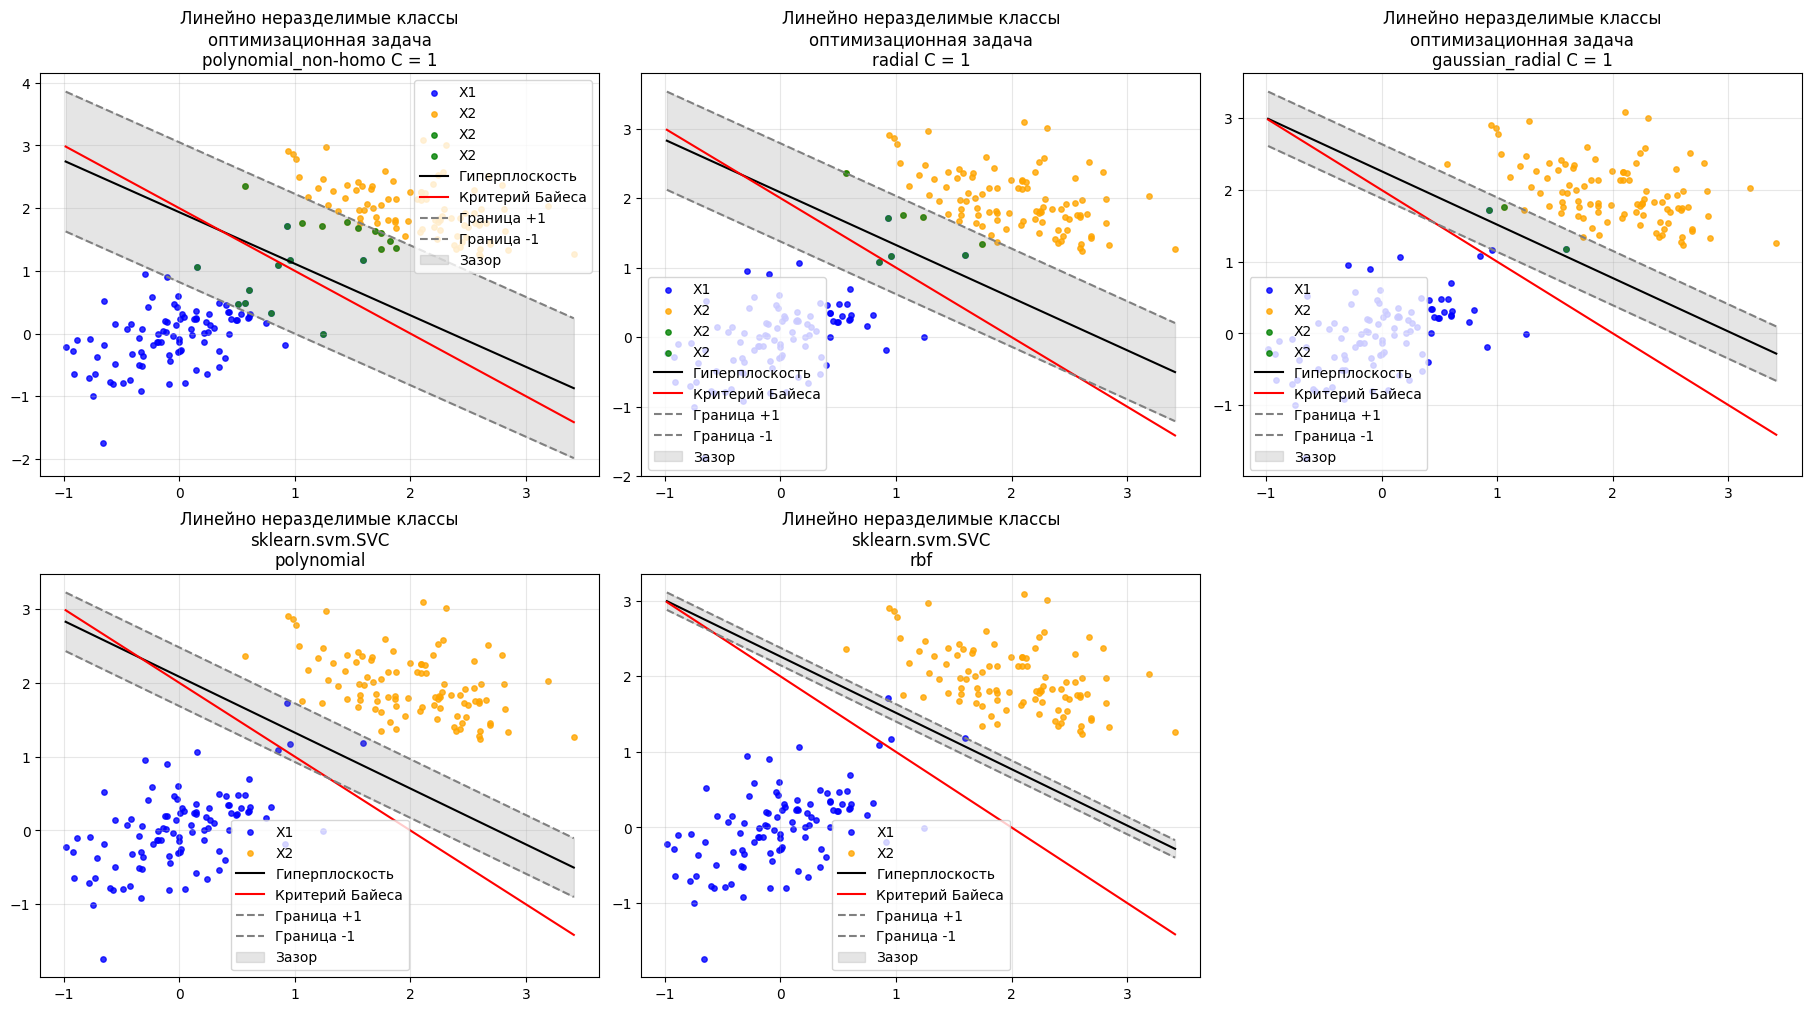

In [ ]:
plt.figure(figsize=(18,10), constrained_layout=True)

plt.subplot(2,3,1)
plt.title(f"Линейно неразделимые классы\nоптимизационная задача\n{kernels[1]} C = 1")
plt.scatter(X1_samples2[:,0], X1_samples2[:,1], s=15, label='X1', alpha=0.8, color="blue")
plt.scatter(X2_samples2[:,0], X2_samples2[:,1], s=15, label='X2', alpha=0.8, color="orange")
plt.scatter(points11[:,0], points11[:,1], s=15, label='X2', alpha=0.8, color='green')
plt.scatter(points12[:,0], points12[:,1], s=15, label='X2', alpha=0.8, color='green')
plt.plot(x1, y1, label='Гиперплоскость', color="black")
plt.plot(x_Bayes, y_Bayes, label='Критерий Байеса', color="red")
plt.plot(x1, y_plus1, label='Граница +1', color='gray', linestyle="--")
plt.plot(x1, y_minus1, label='Граница -1', color='gray', linestyle="--")
plt.fill_between(x1, y_minus1, y_plus1, color='gray', alpha=0.2, label='Зазор')
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(2,3,2)
plt.title(f"Линейно неразделимые классы\nоптимизационная задача\n{kernels[2]} C = 1")
plt.scatter(X1_samples2[:,0], X1_samples2[:,1], s=15, label='X1', alpha=0.8, color="blue")
plt.scatter(X2_samples2[:,0], X2_samples2[:,1], s=15, label='X2', alpha=0.8, color="orange")
plt.scatter(points21[:,0], points21[:,1], s=15, label='X2', alpha=0.8, color='green')
plt.scatter(points22[:,0], points22[:,1], s=15, label='X2', alpha=0.8, color='green')
plt.plot(x2, y2, label='Гиперплоскость', color="black")
plt.plot(x_Bayes, y_Bayes, label='Критерий Байеса', color="red")
plt.plot(x2, y_plus2, label='Граница +1', color='gray', linestyle="--")
plt.plot(x2, y_minus2, label='Граница -1', color='gray', linestyle="--")
plt.fill_between(x2, y_minus2, y_plus2, color='gray', alpha=0.2, label='Зазор')
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(2,3,3)
plt.title(f"Линейно неразделимые классы\nоптимизационная задача\n{kernels[3]} C = 1")
plt.scatter(X1_samples2[:,0], X1_samples2[:,1], s=15, label='X1', alpha=0.8, color="blue")
plt.scatter(X2_samples2[:,0], X2_samples2[:,1], s=15, label='X2', alpha=0.8, color="orange")
plt.scatter(points31[:,0], points31[:,1], s=15, label='X2', alpha=0.8, color='green')
plt.scatter(points32[:,0], points32[:,1], s=15, label='X2', alpha=0.8, color='green')
plt.plot(x3, y3, label='Гиперплоскость', color="black")
plt.plot(x_Bayes, y_Bayes, label='Критерий Байеса', color="red")
plt.plot(x3, y_plus3, label='Граница +1', color='gray', linestyle="--")
plt.plot(x3, y_minus3, label='Граница -1', color='gray', linestyle="--")
plt.fill_between(x3, y_minus3, y_plus3, color='gray', alpha=0.2, label='Зазор')
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(2,3,4)
plt.title("Линейно неразделимые классы\nsklearn.svm.SVC\npolynomial")
plt.scatter(X1_samples2[:,0], X1_samples2[:,1], s=15, label='X1', alpha=0.8, color="blue")
plt.scatter(X2_samples2[:,0], X2_samples2[:,1], s=15, label='X2', alpha=0.8, color="orange")
plt.plot(x2_svc, y2_svc, label='Гиперплоскость', color="black")
plt.plot(x_Bayes, y_Bayes, label='Критерий Байеса', color="red")
plt.plot(x2_svc, y_plus2_svc, label='Граница +1', color='gray', linestyle="--")
plt.plot(x2_svc, y_minus2_svc, label='Граница -1', color='gray', linestyle="--")
plt.fill_between(x2_svc, y_minus2_svc, y_plus2_svc, color='gray', alpha=0.2, label='Зазор')
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(2,3,5)
plt.title("Линейно неразделимые классы\nsklearn.svm.SVC\nrbf")
plt.scatter(X1_samples2[:,0], X1_samples2[:,1], s=15, label='X1', alpha=0.8, color="blue")
plt.scatter(X2_samples2[:,0], X2_samples2[:,1], s=15, label='X2', alpha=0.8, color="orange")
plt.plot(x3_svc, y3_svc, label='Гиперплоскость', color="black")
plt.plot(x_Bayes, y_Bayes, label='Критерий Байеса', color="red")
plt.plot(x3_svc, y_plus3_svc, label='Граница +1', color='gray', linestyle="--")
plt.plot(x3_svc, y_minus3_svc, label='Граница -1', color='gray', linestyle="--")
plt.fill_between(x3_svc, y_minus3_svc, y_plus3_svc, color='gray', alpha=0.2, label='Зазор')
plt.grid(True, alpha=0.3)
plt.legend()

plt.show()